In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [2]:
# initialize spark session
spark = SparkSession.builder.appName("YelpDataAnalysis").getOrCreate()

24/11/17 23:41:13 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/17 23:41:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/17 23:41:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load yelp business data
yelp_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
arizona_df = yelp_df.filter(yelp_df["state"] == "AZ")

24/11/17 23:41:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
# Filter health and med businesses in AZ
health_med_df = arizona_df.filter(arizona_df["categories"].contains("Health & Medical"))
health_med_df.createOrReplaceTempView("health_med")

In [5]:
health_med_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|4582 N 1st Ave, S...|{True, null, null...|E_kLUlU60fzoZYAOx...|Pain Management, ...|Tucson|{7:0-16:30, 7:0-1...|      1|32.2891826|-110.9572299|Pain Institute of...|      85718|          43|  2.5|   AZ|
|6365 E Tanque Ver...|                null|pIUQz-zGw-Nu_Pu-q...|Health & Medical,...|Tucson|{8:0-12:0, 8:0-17...|      1|32.2457767|-110.8573874|Western Endocrine...|      85715|      

### Query 1:

In [6]:
# Cities with most health_med businesses in Arizona
cities_most_health_bus = spark.sql("""
                    SELECT city, COUNT(*) AS num_bus
                    FROM health_med
                    GROUP BY city
                    ORDER BY num_bus DESC
                    LIMIT 10
                    """)
cities_most_health_bus.show()

+----------------+-------+
|            city|num_bus|
+----------------+-------+
|          Tucson|    966|
|      Oro Valley|     45|
|          Marana|      6|
|    Green Valley|      5|
|            Vail|      4|
|       Sahuarita|      4|
|    South Tucson|      1|
|Corona de Tucson|      1|
+----------------+-------+



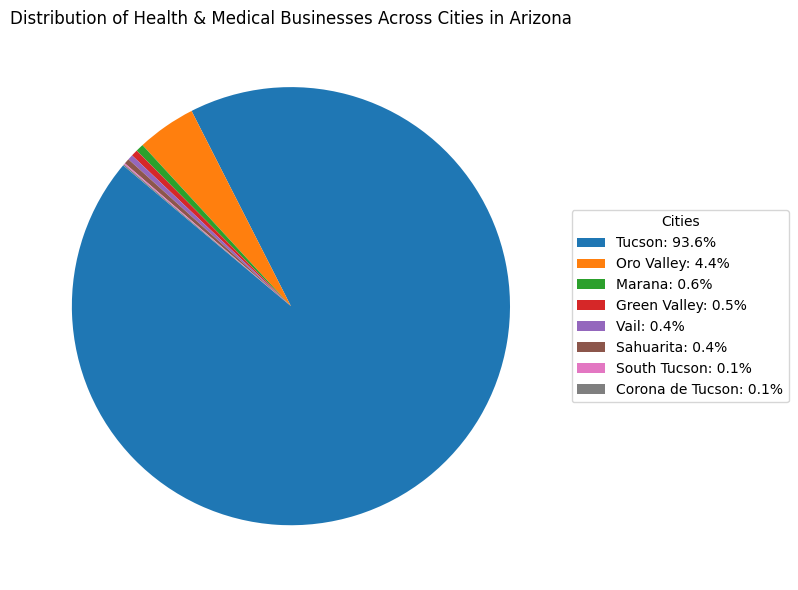

In [7]:
cities_most_health_bus_df = cities_most_health_bus.toPandas()

# Plot query 1 result
plt.figure(figsize=(10, 6))

wedges, texts = plt.pie(cities_most_health_bus_df["num_bus"], startangle=140, colors=plt.cm.tab10.colors)
labels = [
    f"{city}: {count / sum(cities_most_health_bus_df['num_bus']) * 100:.1f}%" 
    for city, count in cities_most_health_bus_df[['city', 'num_bus']].values
]
plt.legend(wedges, labels, title="Cities", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Distribution of Health & Medical Businesses Across Cities in Arizona")
plt.tight_layout()
plt.show()

In [8]:
reviews_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")

In [9]:
reviews_df.createOrReplaceTempView("reviews")

In [10]:
reviews_df.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

### Query 2:

In [11]:
postcode_ratings = spark.sql("""
                            SELECT h.postal_code, AVG(r.stars) AS avg_rating, COUNT(r.review_id) AS num_reviews
                            FROM health_med h
                            JOIN reviews r ON h.business_id = r.business_id
                            GROUP BY h.postal_code
                            HAVING COUNT(r.review_id) > 10
                            ORDER BY avg_rating DESC
                            LIMIT 10
                            """)
postcode_ratings.show()

+-----------+------------------+-----------+
|postal_code|        avg_rating|num_reviews|
+-----------+------------------+-----------+
|      85658|             4.275|         40|
|      85742| 4.103174603174603|        126|
|      85716| 4.009389671361502|       1065|
|      85749| 3.989247311827957|         93|
|      85701|3.9551282051282053|        156|
|      85737|3.9419354838709677|        310|
|      85715| 3.765695067264574|        892|
|      85756|3.7333333333333334|         45|
|      85750|3.6901408450704225|        142|
|      85718|3.6896284829721364|       1292|
+-----------+------------------+-----------+



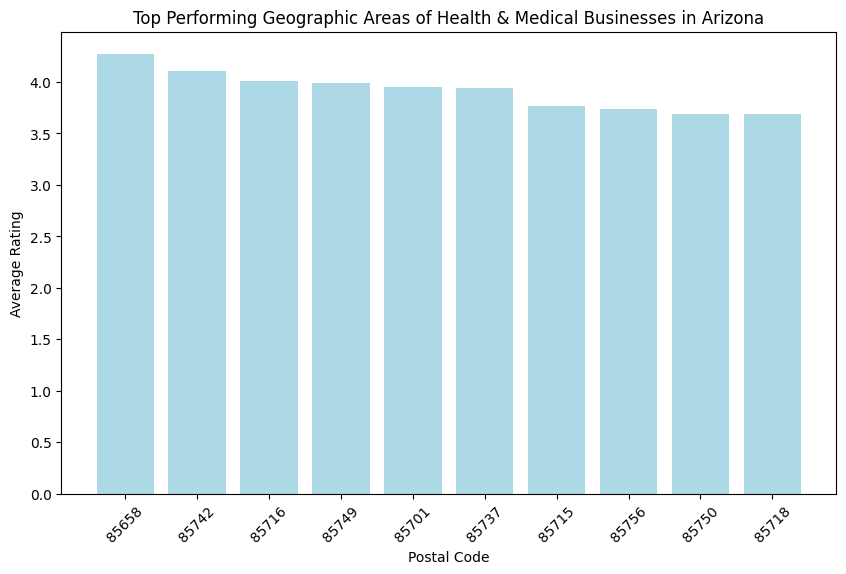

In [12]:
postcode_ratings_df = postcode_ratings.toPandas()

# plot query 2 result
plt.figure(figsize=(10, 6))

plt.bar(postcode_ratings_df["postal_code"], postcode_ratings_df["avg_rating"], color="lightblue")
plt.xlabel("Postal Code")
plt.ylabel("Average Rating")
plt.title("Top Performing Geographic Areas of Health & Medical Businesses in Arizona")
plt.xticks(rotation=45)
plt.show()

### Query 3:

In [13]:
# Most popular health & med business in AZ
most_popular_health_med = spark.sql("""
            SELECT h.name, h.city, AVG(r.stars) AS avg_rating, COUNT(r.review_id) AS review_count
            FROM health_med h
            JOIN reviews r ON h.business_id = r.business_id
            GROUP BY h.name, h.city
            HAVING AVG(r.stars) >= 4
            ORDER BY review_count DESC, avg_rating DESC
            """)
most_popular_health_med.show()

+--------------------+----------+------------------+------------+
|                name|      city|        avg_rating|review_count|
+--------------------+----------+------------------+------------+
|Southern Arizona ...|    Tucson| 4.379790940766551|         287|
|Southern Arizona ...|Oro Valley| 4.228070175438597|         171|
|Skinjectables Ant...|    Tucson| 4.491124260355029|         169|
|Family Vision Center|    Tucson|  4.68595041322314|         121|
|Lotus Massage & W...|    Tucson| 4.844660194174757|         103|
|    Prestige Fitness|    Tucson| 4.371134020618556|          97|
|     The Fix Medical|    Tucson| 4.753246753246753|          77|
|  Lash Factor Studio|    Tucson| 4.584415584415584|          77|
|Mia Bella Salon &...|    Tucson| 4.324675324675325|          77|
|         Skin Appeal|    Tucson| 4.565217391304348|          69|
|        Session Yoga|    Tucson| 4.641791044776119|          67|
| Spa Solai - Skyline|    Tucson| 4.121212121212121|          66|
|Tucson Ma

In [14]:
most_popular_health_med_df = most_popular_health_med.toPandas()

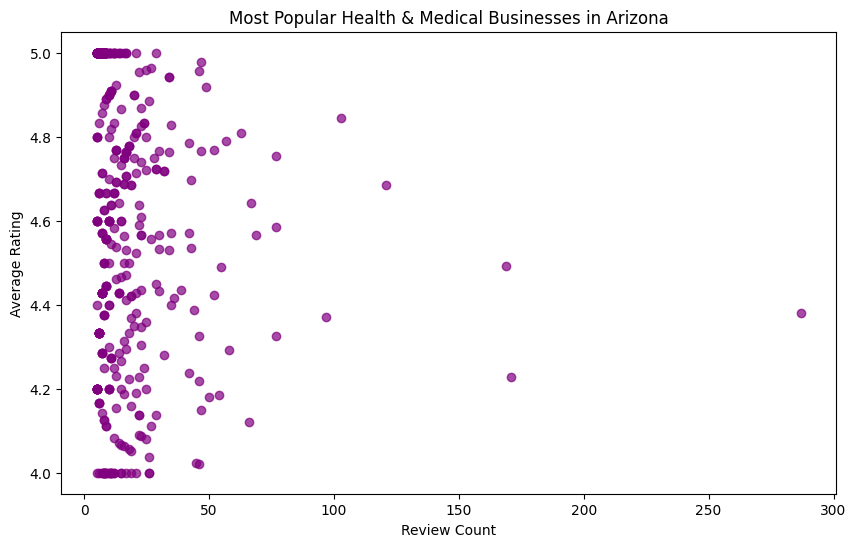

In [15]:
# plot query 3 result
plt.figure(figsize=(10, 6))
plt.scatter(most_popular_health_med_df["review_count"], most_popular_health_med_df["avg_rating"], alpha=0.7, color="purple")
plt.xlabel("Review Count")
plt.ylabel("Average Rating")
plt.title("Most Popular Health & Medical Businesses in Arizona")
plt.show()

### Query 4:

In [16]:
# monthly review trend
monthly_rev_trend = spark.sql("""
                            SELECT EXTRACT(MONTH FROM r.date) AS month, COUNT(r.review_id) AS num_reviews
                            FROM reviews r
                            JOIN health_med h ON r.business_id = h.business_id
                            GROUP BY month
                            ORDER BY month
                            """)
monthly_rev_trend.show()

+-----+-----------+
|month|num_reviews|
+-----+-----------+
|    1|       1647|
|    2|       1428|
|    3|       1599|
|    4|       1499|
|    5|       1589|
|    6|       1539|
|    7|       1564|
|    8|       1747|
|    9|       1539|
|   10|       1669|
|   11|       1518|
|   12|       1465|
+-----+-----------+



In [17]:
monthly_rev_trend_df = monthly_rev_trend.toPandas()

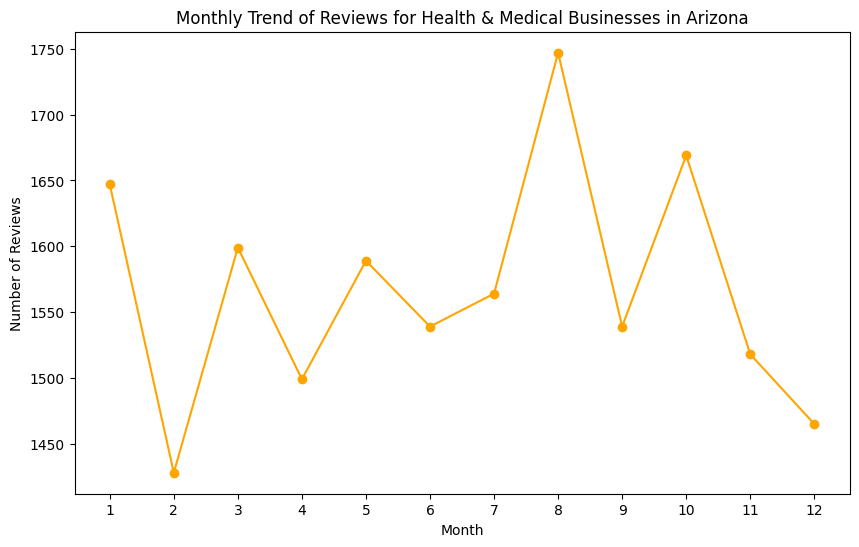

In [18]:
# plot query 4 result
plt.figure(figsize=(10, 6))
plt.plot(monthly_rev_trend_df["month"], monthly_rev_trend_df["num_reviews"], marker="o", color="orange")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Trend of Reviews for Health & Medical Businesses in Arizona")
plt.xticks(monthly_rev_trend_df["month"])
plt.show()

### Query 5:

In [29]:
# Health and Med subcategories with highest avg rating
subcat_avg_rating = spark.sql("""
                                SELECT TRIM(SPLIT(h.categories, ",")[0]) AS focus_area, h.city, AVG(r.stars) AS avg_rating, COUNT(r.review_id) AS num_reviews
                                FROM health_med h
                                JOIN reviews r ON h.business_id = r.business_id
                                GROUP BY TRIM(SPLIT(h.categories, ",")[0]), h.city
                                HAVING COUNT(r.review_id) > 20
                                ORDER BY avg_rating DESC
                                LIMIT 10
                                """)
subcat_avg_rating.show()

+--------------------+----------+-----------------+-----------+
|          focus_area|      city|       avg_rating|num_reviews|
+--------------------+----------+-----------------+-----------+
|Hypnosis/Hypnothe...|    Tucson|4.833333333333333|         48|
|Cosmetics & Beaut...|    Tucson|4.809523809523809|         21|
|       Hair Stylists|    Tucson|4.782608695652174|         23|
|       Orthodontists|Oro Valley|4.764705882352941|         34|
|  Nurse Practitioner|    Tucson|4.724137931034483|         29|
|       Orthodontists|    Marana|4.555555555555555|         27|
|Traditional Chine...|    Tucson|             4.55|        120|
|        Herbal Shops|    Tucson|4.518518518518518|         27|
|       Chiropractors|    Tucson|4.486486486486487|        222|
|         Active Life|    Tucson|4.464285714285714|         84|
+--------------------+----------+-----------------+-----------+



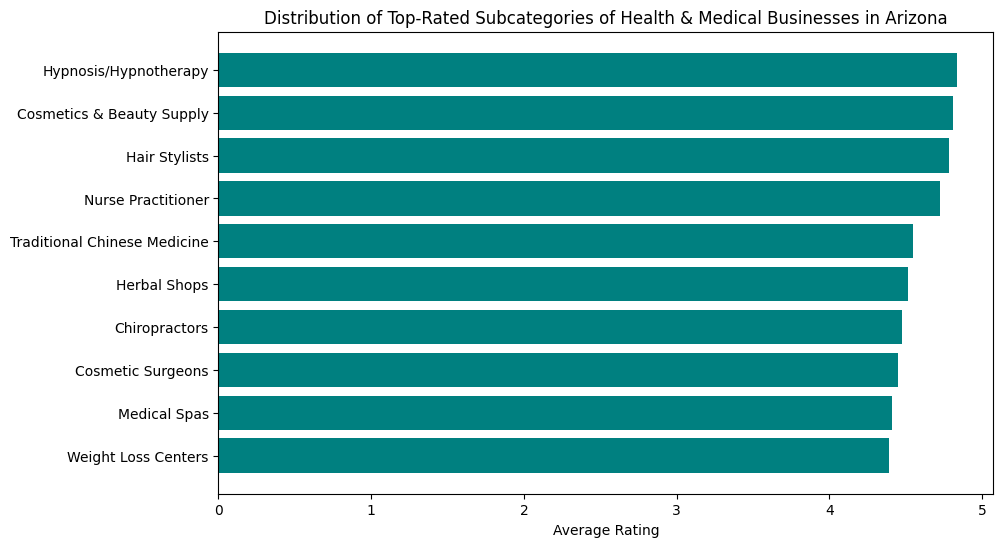

In [22]:
subcat_avg_rating_df = subcat_avg_rating.toPandas()

# plot query 2 result
plt.figure(figsize=(10, 6))

plt.barh(subcat_avg_rating_df["focus_area"], subcat_avg_rating_df["avg_rating"], color="teal")
plt.xlabel("Average Rating")
plt.title("Distribution of Top-Rated Subcategories of Health & Medical Businesses in Arizona")
plt.gca().invert_yaxis()
plt.show()